# Electricity Demand Forecasting

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    1. [Clean Data Frame](#clean_data)<br>
    2. [Data Split](#data_split)<br>




### <a id='import'> 1. Import Modules</a>

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

In [2]:
warnings.filterwarnings('ignore')

### 2. Data Import <a id='read_data'></a>

In [3]:
data_file = '../data/big_demand_temp_train_by_day.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.A Clean the data frame <a id='clean_data'></a>

In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 852 entries, 2015-07-06 to 2017-11-03
Data columns (total 9 columns):
day_demand    852 non-null float64
CA_pop        852 non-null float64
la_high       852 non-null float64
sd_high       852 non-null float64
sj_high       852 non-null float64
sf_high       852 non-null float64
sac_high      852 non-null float64
f_high        852 non-null float64
DOW           852 non-null float64
dtypes: float64(9)
memory usage: 66.6 KB


In [6]:
full_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0


#### 2.B Extending Exogenous Regressors To Include Day Of Week <a id='extend_dow'></a>

In [7]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names
new_df.head()

,day_demand,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,Mon,Tue,Wed,Thur,Fri,Sat,Sun
2015-07-06,834762.0,13845790.0,76.53,69.43,79.45,68.22,91.88,95.83,0.0,1,0,0,0,0,0,0
2015-07-07,825173.0,13845790.0,77.05,69.61,79.38,68.29,90.67,92.31,1.0,0,1,0,0,0,0,0
2015-07-08,804819.0,13845790.0,73.90,70.08,74.78,64.59,86.60,91.83,2.0,0,0,1,0,0,0,0
2015-07-09,782610.0,13845790.0,74.22,71.30,74.00,63.23,78.27,88.91,3.0,0,0,0,1,0,0,0
2015-07-10,769752.0,13845790.0,74.57,73.32,73.66,68.02,78.92,82.60,4.0,0,0,0,0,1,0,0


#### 2.C Data Split <a id='data_split'></a>

In [8]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [9]:
# Split the data frame into two parts
train_len = int(0.7 * data_len)
window_len = int(0.1 * data_len)

In [10]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [11]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 596 entries, 2015-07-06 to 2017-02-20
Data columns (total 16 columns):
day_demand    596 non-null float64
CA_pop        596 non-null float64
la_high       596 non-null float64
sd_high       596 non-null float64
sj_high       596 non-null float64
sf_high       596 non-null float64
sac_high      596 non-null float64
f_high        596 non-null float64
DOW           596 non-null float64
Mon           596 non-null uint8
Tue           596 non-null uint8
Wed           596 non-null uint8
Thur          596 non-null uint8
Fri           596 non-null uint8
Sat           596 non-null uint8
Sun           596 non-null uint8
dtypes: float64(9), uint8(7)
memory usage: 50.6 KB


----
----
#### Walk Forward
----

In [34]:
full_df['log_demand'] = np.log(full_df['day_demand'])

In [45]:
full_df.shape

(852, 10)

In [35]:
def data_block(X, start, out_size) :
    # get the slices of data frames to provide the blocks requested
    block1 = X.iloc[start:start+out_size, :]
        
    return block1
    

In [40]:
def sarimax_walk_forward_val(data, start_size, val_window, regressors, steps) :
    '''
        Function: sarimax_walk_forward_val
        
        Arguments:
            model - model class instantiator
            data - pandas dataframe containing data of interest
            start_size - initial number of rows for training
            val_window - size of the validation window for each trail
            regressors - list of regressors to add to the model
            steps - number of walk forward steps to run
        
        Return:
            mape_list - list of tupels with the last index for training window and mape for the window
    '''
    # Now choose the results that seem to work the best above and fit the model

    best_order3 = (5, 0, 0)
    best_seasonal_order3 = (3, 0, 1, 7)
    
    mape_list = []
    # for each steps
    for step in range(steps) :
        print(start_size+step*val_window)
        # Get the block of data for training
        train_dat = data_block(data, 0, start_size+step*val_window)
        
        # Get a block of data for validation
        val_dat = data_block(data, start_size+step*val_window, val_window)
        

        model = SARIMAX(data['log_demand'], order=best_order3, \
                    seasonal_order=best_seasonal_order3, exog=data[exog_columns])
        res = model.fit()
        
        # Forecast for the validation step
        predict3 = res3.get_forecast(val_window, exog=val_dat[best_exog_columns3].values[:val_window, :])
        
        forecast = np.exp(predict3.predicted_mean)
        
        # Caluclate the MAPE for the window
        ape = [np.abs(val_dat['day_demand'].values[x] - forecast[x]) / val_dat['day_demand'].values[x] * 100 for x in range(len(val_dat.index))]
        
        # Add the values to the list
        mape_list.append((train_dat.index[-1], np.mean(ape)))
        
    # return the mape list
    return mape_list

In [46]:
exog_columns = ['la_high','f_high']
results = sarimax_walk_forward_val(full_df, 432, 21, exog_columns, 20)

432
453
474
495
516
537
558
579
600
621
642
663
684
705
726
747
768
789
810
831


In [47]:
results

[(Timestamp('2016-09-09 00:00:00'), 17.048933363299177),
 (Timestamp('2016-09-30 00:00:00'), 11.032835404022311),
 (Timestamp('2016-10-21 00:00:00'), 10.265096241863622),
 (Timestamp('2016-11-11 00:00:00'), 10.096903416184771),
 (Timestamp('2016-12-02 00:00:00'), 13.292966893141685),
 (Timestamp('2016-12-23 00:00:00'), 11.469574712272633),
 (Timestamp('2017-01-13 00:00:00'), 13.747748736124615),
 (Timestamp('2017-02-03 00:00:00'), 10.29793837957546),
 (Timestamp('2017-02-24 00:00:00'), 9.404206132956991),
 (Timestamp('2017-03-17 00:00:00'), 9.511783104413459),
 (Timestamp('2017-04-07 00:00:00'), 10.174598037411268),
 (Timestamp('2017-04-28 00:00:00'), 11.05070672850409),
 (Timestamp('2017-05-19 00:00:00'), 12.77723465762501),
 (Timestamp('2017-06-09 00:00:00'), 21.93878754281061),
 (Timestamp('2017-06-30 00:00:00'), 25.257638506917797),
 (Timestamp('2017-07-21 00:00:00'), 26.51693891986865),
 (Timestamp('2017-08-11 00:00:00'), 23.482806648247582),
 (Timestamp('2017-09-01 00:00:00'), 21

In [49]:
results_prophet = [(pd.Timestamp('2016-09-09 00:00:00'), 4.730140676725979),
 (pd.Timestamp('2016-09-30 00:00:00'), 3.8091507933658373),
 (pd.Timestamp('2016-10-21 00:00:00'), 2.821290084068635),
 (pd.Timestamp('2016-11-11 00:00:00'), 5.488702162801814),
 (pd.Timestamp('2016-12-02 00:00:00'), 3.769910866731833),
 (pd.Timestamp('2016-12-23 00:00:00'), 3.57803948967129),
 (pd.Timestamp('2017-01-13 00:00:00'), 5.88908700518648),
 (pd.Timestamp('2017-02-03 00:00:00'), 3.3303229979021993),
 (pd.Timestamp('2017-02-24 00:00:00'), 12.77014271145789),
 (pd.Timestamp('2017-03-17 00:00:00'), 4.896256192367774),
 (pd.Timestamp('2017-04-07 00:00:00'), 1.6816562416178429),
 (pd.Timestamp('2017-04-28 00:00:00'), 2.55485075968),
 (pd.Timestamp('2017-05-19 00:00:00'), 3.320769459110948),
 (pd.Timestamp('2017-06-09 00:00:00'), 5.454238854374319),
 (pd.Timestamp('2017-06-30 00:00:00'), 6.905574383025765),
 (pd.Timestamp('2017-07-21 00:00:00'), 2.7845896926149414),
 (pd.Timestamp('2017-08-11 00:00:00'), 6.110552446073265),
 (pd.Timestamp('2017-09-01 00:00:00'), 6.319054651650498),
 (pd.Timestamp('2017-09-22 00:00:00'), 7.275415230751364),
 (pd.Timestamp('2017-10-13 00:00:00'), 4.3985740057397855)]

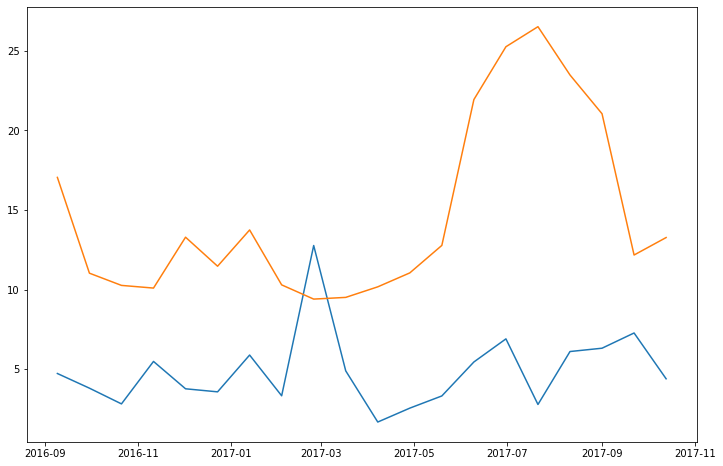

In [53]:
fig = plt.figure(figsize=[12,8])

prophet_results_x = [x[0].date() for x in results_prophet]
prophet_results_y = [x[1] for x in results_prophet]
prophet_timestamps = [x[0].timestamp() for x in results_prophet]

prophet_z = np.polyfit(prophet_timestamps, prophet_results_y, 1)
prophet_poly_func = np.poly1d(prophet_z)
prophet_trend = [prophet_poly_func(x) for x in prophet_timestamps]

plt.plot(prophet_results_x, prophet_results_y)
#plt.plot(prophet_results_x, prophet_trend)

sarima_results_x = [x[0].date() for x in results]
sarima_results_y = [x[1] for x in results]
sarima_timestamps = [x[0].timestamp() for x in results]

sarima_z = np.polyfit(sarima_timestamps, sarima_results_y, 1)
sarima_poly_func = np.poly1d(sarima_z)
sarima_trend = [sarima_poly_func(x) for x in sarima_timestamps]

plt.plot(sarima_results_x, sarima_results_y)
#plt.plot(sarima_results_x, sarima_trend)

In [69]:
predict_steps = 7*3
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

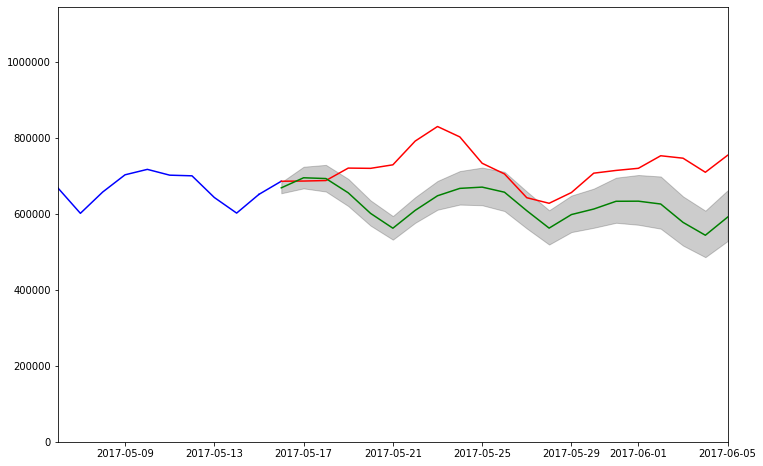

In [70]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk2['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk2['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk2['day_demand'].values[0]], c='b')
plt.plot(X_walk2.index, X_walk2['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

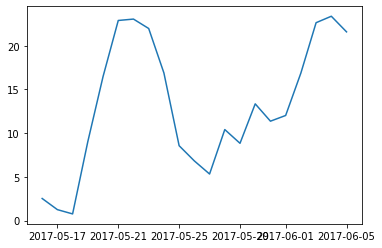

In [71]:
residuals = [abs(X_walk2['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk2['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [74]:
mape22 = np.mean(percent_error[:21])
print(mape22)

13.141280095824474


----
----
### Walk 2
---

In [75]:
X_train = X_train.append(X_walk2)
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 850 entries, 2015-07-06 to 2017-08-08
Data columns (total 14 columns):
CA_pop        850 non-null float64
DOW           850 non-null float64
Fri           850 non-null uint8
Mon           850 non-null uint8
Sat           850 non-null uint8
Sun           850 non-null uint8
Thur          850 non-null uint8
Tue           850 non-null uint8
Wed           850 non-null uint8
day_demand    850 non-null float64
f_high        850 non-null float64
la_high       850 non-null float64
log_demand    850 non-null float64
sd_high       850 non-null float64
dtypes: float64(7), uint8(7)
memory usage: 58.9 KB


In [77]:
# Now choose the results that seem to work the best above and fit the model
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [78]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

In [90]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

#plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk2['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk3['day_demand'].index[0]], \
         [X_train['day_demand'].values[-1], X_walk3['day_demand'].values[0]], c='b')
plt.plot(X_walk3.index, X_walk3['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

ValueError: view limit minimum -35939.200000000004 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

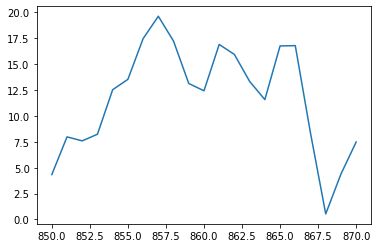

In [91]:
residuals = [abs(X_walk3['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk3['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [93]:
mape33 = np.mean(percent_error[:21])
print(mape33)

11.717834045163718


In [94]:
# Now choose the results that seem to work the best above and fit the model
model3 = SARIMAX(X_train['log_demand'], order=best_order3, seasonal_order=best_seasonal_order3, \
            exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [95]:
predict_steps = 7*3
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

In [96]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk3['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk3['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk3['day_demand'].values[0]], c='b')
plt.plot(X_walk3.index, X_walk3['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

ValueError: year 0 is out of range

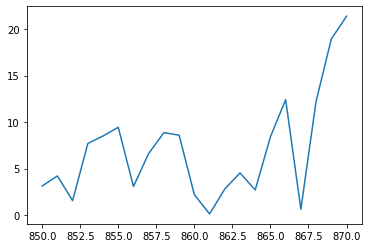

In [97]:
residuals = [abs(X_walk3['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk3['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [98]:
mape3_3 = np.mean(percent_error[:21])
print(mape3_3)

7.049211671614031
